In [ ]:
# Based on datacamp course : https://www.datacamp.com/tutorial/k-means-clustering-python
# Modified by Mehdi Ammi, Univ. Paris 8

# Scikit-Learn: k-Means Clustering

In this notebook, you'll explore the fundamentals of k-means clustering. We'll cover:

 - Understanding the mechanics behind the k-means clustering technique
 - Techniques for visualizing data to assess its suitability for clustering
 - A practical example of applying, optimizing, and analyzing a k-means clustering model using the real-world dataset of California housing.

It's important to distinguish this from the k-nearest neighbors algorithm. For those interested in k-nearest neighbors, refer to the tutorial on k-Nearest Neighbors (KNN) Classification with scikit-learn in Python.

K-means clustering is a widely utilized algorithm that effectively groups data into distinct clusters, particularly useful when data forms spherical shapes. This clustering method is invaluable both as an analytical tool in scenarios where data groupings are not immediately apparent, and as a method of feature engineering to enhance the performance of supervised learning models.

## An Overview of K-Means Clustering

K-means clustering is a technique in data modeling that groups similar data points into distinct clusters. This process can provide insightful analysis or enhance a supervised learning model as a feature.

Imagine a scenario where people are gathered in various groups across a room, engaging in separate conversations. Initially, all you see is a crowd. If you mentally mark the center of each group and assign it a unique identifier, you can then refer to each cluster by this identifier. This illustrates the core concept of k-means clustering, where data is organized into identifiable groups, much like people in a social gathering.

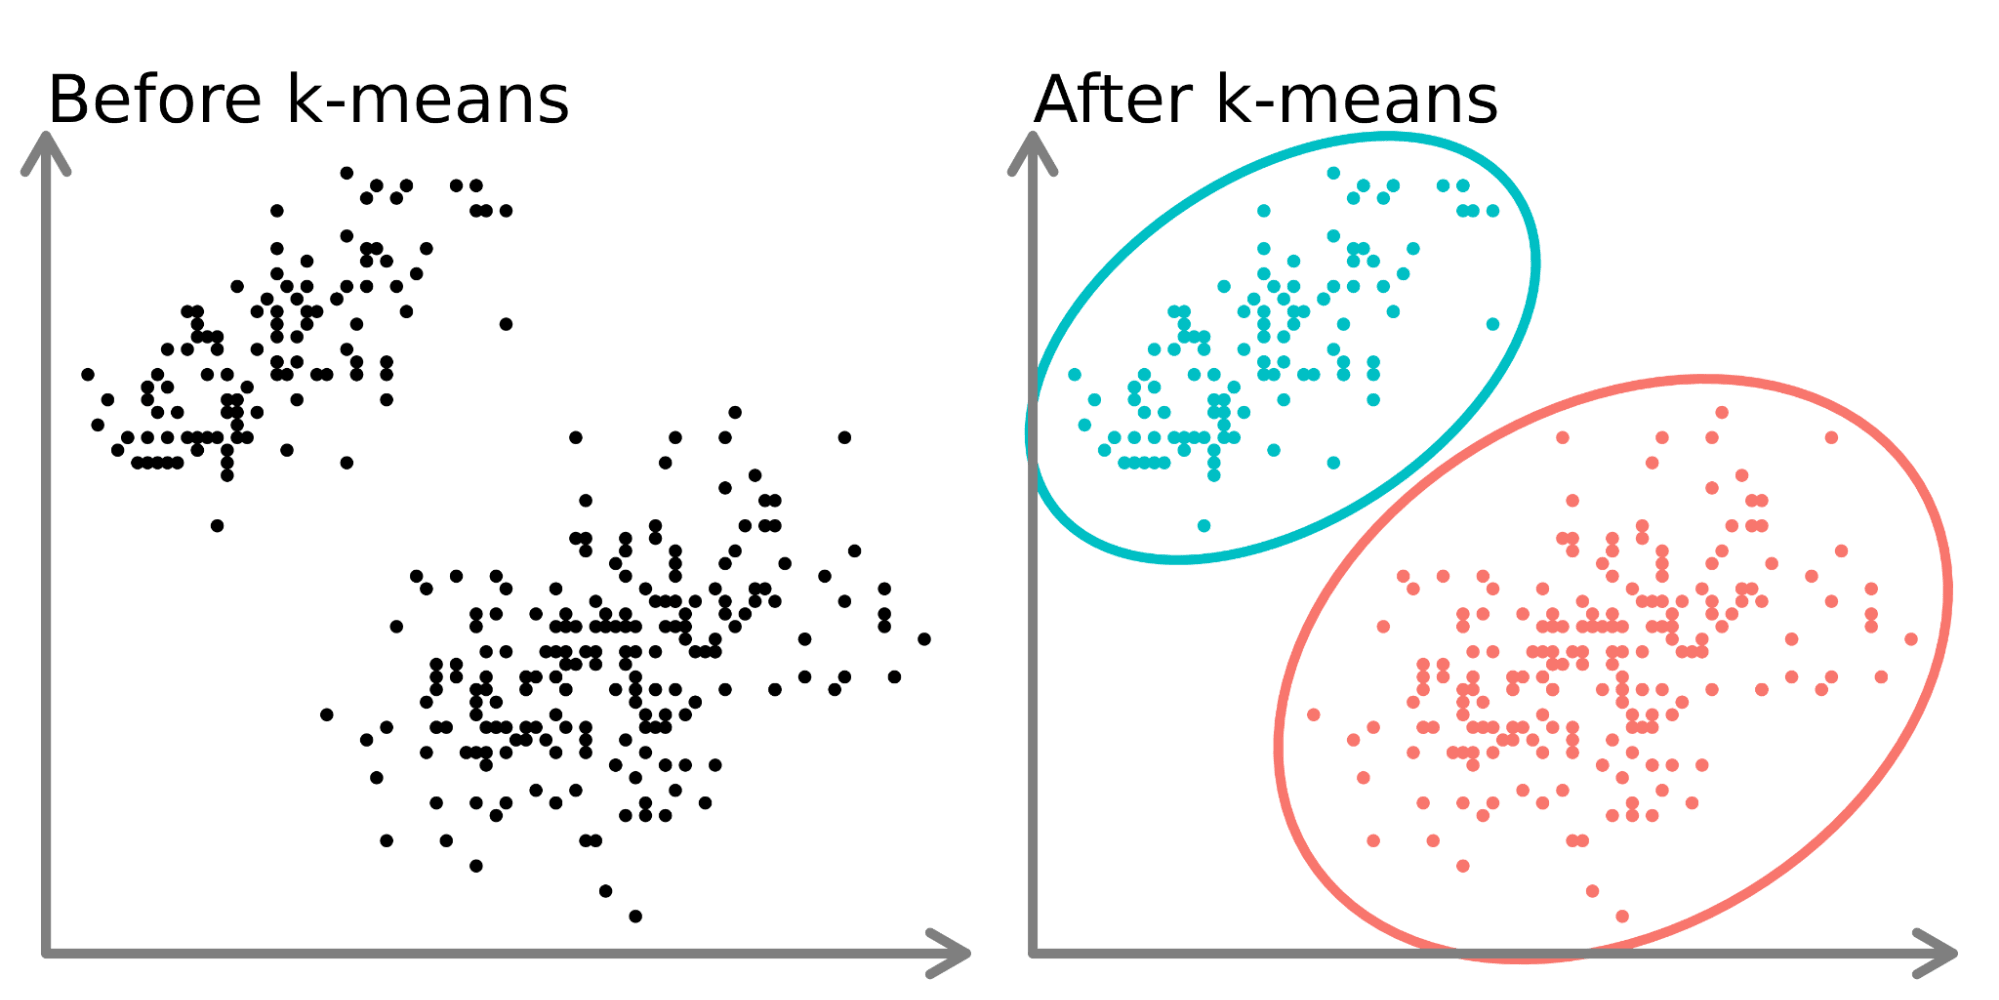

In the left-hand side of the diagram above, we can see 2 distinct sets of points that are unlabeled and colored as similar data points. Fitting a k-means model to this data (right-hand side) can reveal 2 distinct groups (shown in both distinct circles and colors). 

In two dimensions, it is easy for humans to split these clusters, but with more dimensions, you need to use a model.

## Installing Scikit-Learn

In [ ]:
# Install the scikit-learn library using pip
!pip install scikit-learn

Use the pip package installer to install the scikit-learn library, which is a popular machine learning library in Python. It provides tools for modeling and transforming data. 
The ! at the beginning indicates that it's a shell command being run from within a Python environment like a Jupyter notebook.

In [ ]:
>>
Requirement already satisfied: scikit-learn in /usr/local/lib/python3.10/dist-packages (1.2.2)
Requirement already satisfied: numpy>=1.17.3 in /usr/local/lib/python3.10/dist-packages (from scikit-learn) (1.25.2)
Requirement already satisfied: scipy>=1.3.2 in /usr/local/lib/python3.10/dist-packages (from scikit-learn) (1.11.4)
Requirement already satisfied: joblib>=1.1.1 in /usr/local/lib/python3.10/dist-packages (from scikit-learn) (1.4.2)
Requirement already satisfied: threadpoolctl>=2.0.0 in /usr/local/lib/python3.10/dist-packages (from scikit-learn) (3.5.0)

## Importing necessary libraries and modules

In [ ]:
# Import the pandas library for data manipulation and analysis
import pandas as pd
# Import files module from google.colab for file uploading
from google.colab import files

## Load Dateset

In this tutorial, we will be using California housing data from Kaggle (https://www.kaggle.com/datasets/camnugent/california-housing-prices?resource=download). We will use location data (latitude and longitude) as well as the median house value. We will cluster the houses by location and observe how house prices fluctuate across California. We save the dataset as a csv file called ‘housing.csv’ in our working directory and read it using pandas.

In [ ]:
# Prompt user to upload files and store the uploaded files in a variable
uploaded = files.upload()

# Load the data from a CSV file named 'housing.csv' into a pandas DataFrame
home_data = pd.read_csv("housing.csv")

# Display the first five rows of the DataFrame to preview the data
home_data.head()

|index|longitude|latitude|housing\_median\_age|total\_rooms|total\_bedrooms|population|households|median\_income|median\_house\_value|ocean\_proximity|
|---|---|---|---|---|---|---|---|---|---|---|
|0|-122\.23|37\.88|41\.0|880\.0|129\.0|322\.0|126\.0|8\.3252|452600\.0|NEAR BAY|
|1|-122\.22|37\.86|21\.0|7099\.0|1106\.0|2401\.0|1138\.0|8\.3014|358500\.0|NEAR BAY|
|2|-122\.24|37\.85|52\.0|1467\.0|190\.0|496\.0|177\.0|7\.2574|352100\.0|NEAR BAY|
|3|-122\.25|37\.85|52\.0|1274\.0|235\.0|558\.0|219\.0|5\.6431|341300\.0|NEAR BAY|
|4|-122\.25|37\.85|52\.0|1627\.0|280\.0|565\.0|259\.0|3\.8462|342200\.0|NEAR BAY|

The data include 3 variables that we have selected using the usecols parameter:

 - longitude: A value representing how far west a house is. Higher values represent houses that are further West.
 - latitude: A value representing how far north a house is. Higher values represent houses that are further north.
 - median_house_value: The median house price within a block measured in USD. 

## Visualize the Data

We start by visualizing our housing data. We look at the location data with a heatmap based on the median price in a block. We will use Seaborn to quickly create plots in this tutorial

In [ ]:
# Import the seaborn library for statistical data visualization
import seaborn as sns

# Create a scatter plot using seaborn. The plot uses the 'home_data' DataFrame,
# with 'longitude' as the x-axis and 'latitude' as the y-axis. 
# The color coding ('hue') of the points is based on the 'median_house_value' column.
sns.scatterplot(data = home_data, x = 'longitude', y = 'latitude', hue = 'median_house_value')

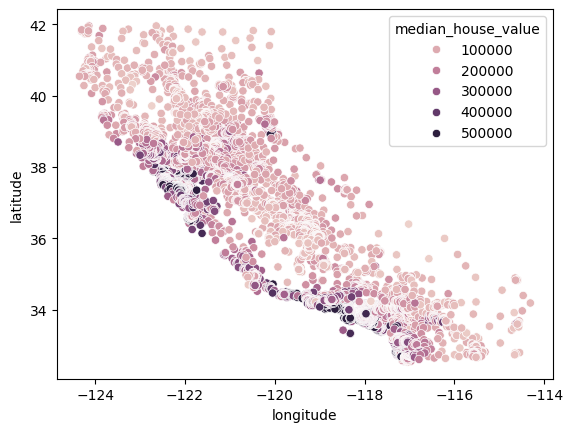

It's observed that the highest-priced homes are predominantly located along California's west coast, with various zones featuring clusters of homes at moderate prices. This trend aligns with the common understanding that properties near the waterfront generally have higher values than those inland.

Identifying clusters becomes straightforward when only two or three variables are involved. However, the task can become challenging or even unfeasible as the number of features increases.

## Normalizing the Data

When working with distance-based algorithms, like k-Means Clustering, we must normalize the data. If we do not normalize the data, variables with different scaling will be weighted differently in the distance formula that is being optimized during training. For example, if we were to include price in the cluster, in addition to latitude and longitude, price would have an outsized impact on the optimizations because its scale is significantly larger and wider than the bounded location variables. 

We first set up training and test splits using train_test_split from sklearn. 

In [ ]:
# Import the train_test_split function from the model_selection module of scikit-learn
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets:
# - X_train, X_test: These variables will store the training and testing sets of the features ('latitude' and 'longitude')
# - y_train, y_test: These variables will store the training and testing sets of the target variable ('median_house_value')
# - test_size=0.33: This parameter specifies that 33% of the data will be used for the test set, and the remaining 67% will be used for the training set
# - random_state=0: This parameter is a seed value that ensures the split of the data is reproducible; the same split will occur each time the code is run
X_train, X_test, y_train, y_test = train_test_split(home_data[['latitude', 'longitude']], home_data[['median_house_value']], test_size=0.33, random_state=0)

Next, we normalize the training and test data using the preprocessing.normalize() method from sklearn. 

In [ ]:
# Import the preprocessing module from the scikit-learn library for data scaling functions
from sklearn import preprocessing

# Normalize the training data to ensure each feature vector has unit norm, enhancing model performance
X_train_norm = preprocessing.normalize(X_train)

# Apply the same normalization to the testing data to maintain consistency in data processing
X_test_norm = preprocessing.normalize(X_test)

## Fitting and Evaluating the Model

For the first iteration, we will arbitrarily choose a number of clusters (referred to as k) of 3. Building and fitting models in sklearn is very simple. We will create an instance of KMeans, define the number of clusters using the n_clusters attribute, set n_init, which defines the number of iterations the algorithm will run with different centroid seeds, to “auto,” and we will set the random_state to 0 so we get the same result each time we run the code.  We can then fit the model to the normalized training data using the fit() method.

In [ ]:
# Import the KMeans clustering algorithm from scikit-learn's cluster module
from sklearn.cluster import KMeans

# Initialize the KMeans clustering algorithm:
# - n_clusters = 3: Specifies the number of clusters to form as well as the number of centroids to generate.
# - random_state = 0: Ensures reproducibility of the results by using the same seed for the random number generator.
# - n_init = 'auto': The method to use for initializing the centroids. 'auto' sets it to 'k-means++' if available.
kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')

# Fit the KMeans model on the normalized training data to identify cluster patterns
kmeans.fit(X_train_norm)

Once the data are fit, we can access labels from the labels_ attribute. Below, we visualize the data we just fit. 

In [ ]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = kmeans.labels_)

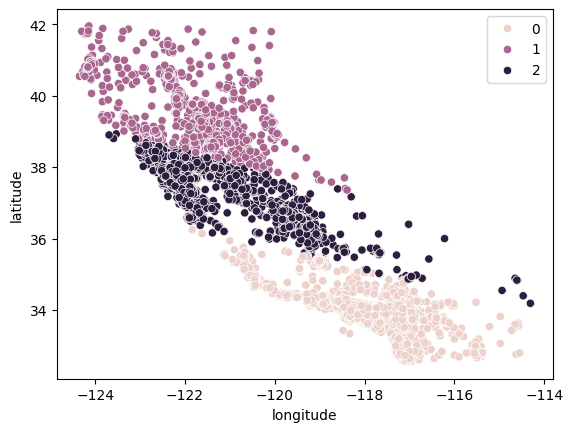

We see that the data are now clearly split into 3 distinct groups (Northern California, Central California, and Southern California). We can also look at the distribution of median house prices in these 3 groups using a boxplot. 

In [ ]:
# Use seaborn's boxplot function to visualize the distribution of 'median_house_value' across different clusters:
# - x = kmeans.labels_: Specifies the x-axis values as the cluster labels obtained from the KMeans algorithm. Each label represents a cluster.
# - y = y_train['median_house_value']: Specifies the y-axis values as the 'median_house_value' from the training dataset, showing the spread of house values within each cluster.
sns.boxplot(x = kmeans.labels_, y = y_train['median_house_value'], palette='viridis')

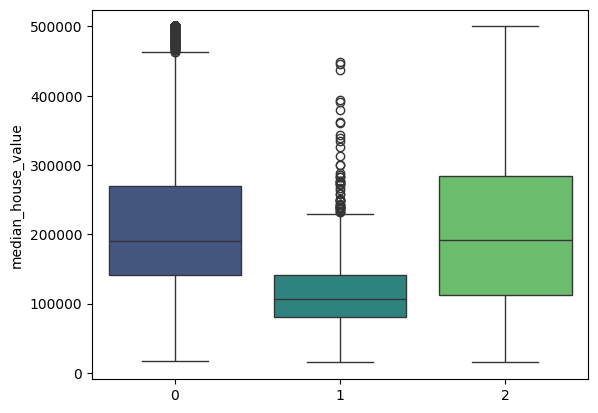

We clearly see that the Northern and Southern clusters have similar distributions of median house values (clusters 0 and 2) that are higher than the prices in the central cluster (cluster 1). 

We can evaluate performance of the clustering algorithm using a Silhouette score which is a part of sklearn.metrics where a lower score represents a better fit.

In [ ]:
# Import the silhouette_score function from scikit-learn's metrics module
from sklearn.metrics import silhouette_score

# Calculate the silhouette score for the clustering:
# - X_train_norm: The normalized feature set used for clustering.
# - kmeans.labels_: The cluster labels assigned to each data point by the KMeans algorithm.
# - metric='euclidean': Specifies the use of the Euclidean distance metric for calculating the silhouette score.
silhouette_score(X_train_norm, kmeans.labels_, metric='euclidean')

In [ ]:
>>
0.7499371920703546

Since we have not looked at the strength of different numbers of clusters, we do not know how good of a fit the k = 3 model is. In the next section, we will explore different clusters and compare performance to make a decision on the best hyperparameter values for our model.

## Choosing the best number of clusters

The weakness of k-means clustering is that we don’t know how many clusters we need by just running the model. We need to test ranges of values and make a decision on the best value of k. We typically make a decision using the Elbow method to determine the optimal number of clusters where we are both not overfitting the data with too many clusters, and also not underfitting with too few. 

We create the below loop to test and store different model results so that we can make a decision on the best number of clusters.

In [ ]:
# Define a range for the number of clusters (from 2 to 7)
K = range(2, 8)

# Initialize a list to store the fitted models for each value of k
fits = []

# Initialize a list to store the silhouette scores corresponding to each k
score = []

# Loop through each value of k in the specified range
for k in K:
    # Train a KMeans model with 'k' clusters on the normalized training data
    # - n_clusters=k: Number of clusters to form and number of centroids to generate
    # - random_state=0: Ensures the results are reproducible
    # - n_init='auto': Automatically chooses a method for initializing centroids (default 'k-means++')
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(X_train_norm)
    
    # Store the trained model in the 'fits' list
    fits.append(model)
    
    # Calculate the silhouette score for the clustering with 'k' clusters
    # The score measures how similar an object is to its own cluster compared to other clusters
    # A higher silhouette score indicates better defined clusters
    # - X_train_norm: Input features that were used for clustering
    # - model.labels_: Labels of the clusters assigned by the model
    # - metric='euclidean': Uses Euclidean distance to calculate the silhouette score
    score.append(silhouette_score(X_train_norm, model.labels_, metric='euclidean'))

We can then first visually look at a few different values of k. 

First we look at k = 2.

In [ ]:
# Use seaborn's scatterplot function to visualize the geographical distribution of clusters:
# - data = X_train: Specifies the dataset to use for the plot, which includes geographical coordinates.
# - x = 'longitude': Assigns the 'longitude' column from X_train as the x-axis values.
# - y = 'latitude': Assigns the 'latitude' column from X_train as the y-axis values.
# - hue = fits[0].labels_: Colors the data points based on the cluster labels assigned by the first KMeans model in the 'fits' list.
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[0].labels_)

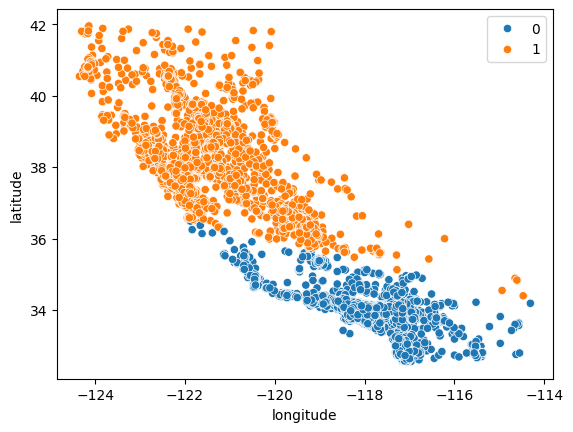

The model does an ok job of splitting the state into two halves, but probably doesn’t capture enough nuance in the California housing market. 

Next, we look at k = 4. 

In [ ]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[2].labels_)

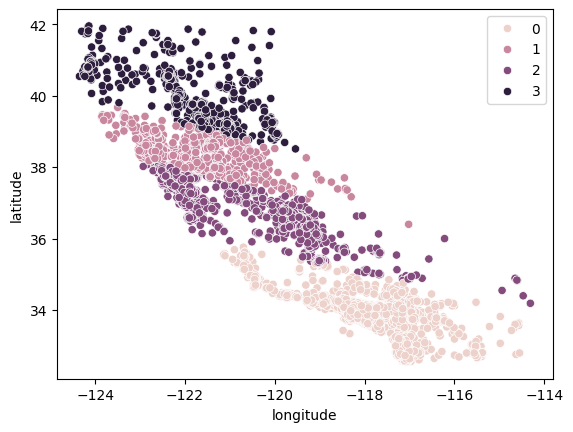

We see this plot groups California into more logical clusters across the state based on how far North or South the houses are in the state. This model most likely captures more nuance in the housing market as we move across the state. 

Finally, we look at k = 7.

sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[5].labels_)

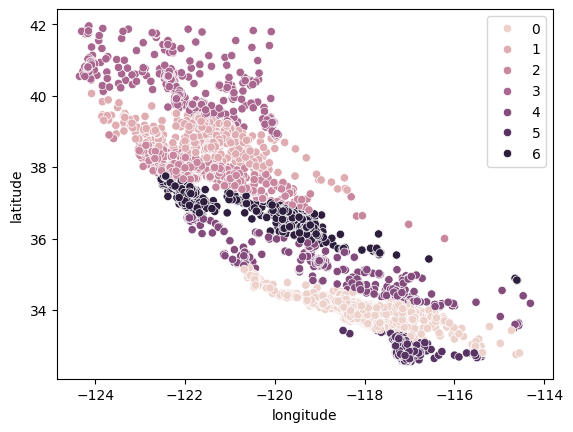

The presented graph seems to contain an excessive number of clusters, complicating the interpretation in favor of a potentially "more precise" geographical clustering.

Generally, increasing the number of clusters (K) initially enhances the definition and representation of each cluster. However, beyond a certain point, the benefits begin to diminish, or the clustering effectiveness may even decline. To aid in selecting the optimal K value, one can utilize an elbow plot. This plot displays the cluster quality (goodness of fit) on the y-axis against the number of clusters (K) on the x-axis, helping to visually identify the point where improvements taper off.

In [ ]:
# Use seaborn's lineplot function to visualize the silhouette scores as a function of the number of clusters (K):
# - x = K: Specifies the x-axis values as the range of K values, representing different numbers of clusters tested.
# - y = score: Specifies the y-axis values as the silhouette scores corresponding to each value of K.
# This line plot helps in visually assessing the performance of the clustering algorithm across different numbers of clusters.
sns.lineplot(x = K, y = score)

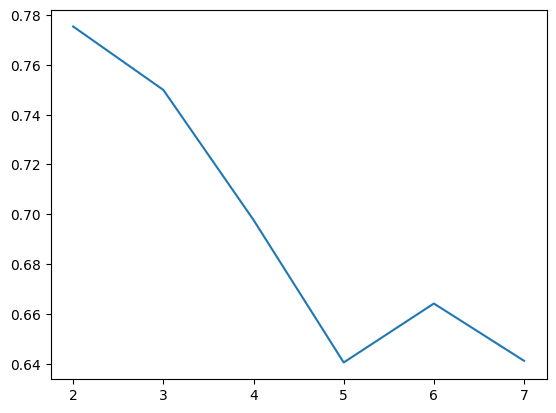

We typically choose the point where the improvements in performance start to flatten or get worse. We see k = 5 is probably the best we can do without overfitting. 

We can also see that the clusters do a relatively good job of breaking California into distinct clusters and these clusters map relatively well to different price ranges as seen below. 

In [ ]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[3].labels_)

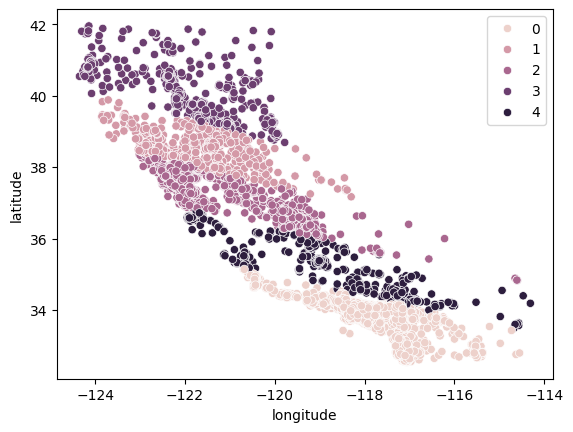

In [ ]:
sns.boxplot(x = fits[3].labels_, y = y_train['median_house_value'])

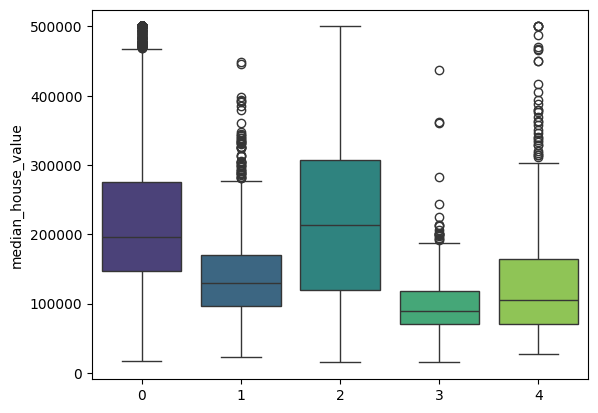

## Limits of k-means

K-means clustering is most effective with spherical datasets, where data points are closely grouped in space. This characteristic allows for easier visualization and analysis in two or three dimensions. When data do not naturally form spherical clusters or are not intended to be spherical, k-means clustering tends to struggle. For instance, k-means may perform poorly with data shaped like concentric circles or arcs. Despite these shapes being visually distinct and requiring different labels, k-means would find it challenging to identify separate centroids for clustering each shape accurately.

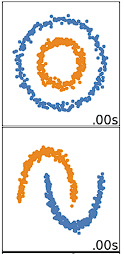

## Excercices

### Excercice 1 : Clustering with Different K Values

 - Perform KMeans clustering on the normalized training data with different values of K (2, 3, 4, 5, 6, 7). Store the silhouette scores for each K.
 - How can you change the distance metric used in silhouette score calculation to 'manhattan'?

### Exercice 2 : Visualize Clusters for a Specific K

 - Visualize Clusters for a Specific K
 - How can you add the cluster centroids to the scatter plot?

### Exercise 3: Compare Clustering Performance

 - Compare the clustering performance for K=3 and K=5 using silhouette scores.
 - How would you include the silhouette score for K=4 in the comparison?
 - How can you use a different metric, such as 'manhattan', for the silhouette score calculation?


### Exercise 4: Cluster Data with Additional Features

 - Perform KMeans clustering using 'latitude', 'longitude', and 'median_income' as features, and visualize the clusters for K=3.
 - How would you change the code to visualize the clusters for K=4?
 - How can you include 'housing_median_age' in the feature set?

### Exercise 5: KMeans Clustering on the "Mall Customers" dataset

Perform KMeans clustering on a new dataset, the "Mall Customers" dataset, to group customers based on their spending score and annual income. Visualize the clusters and analyze the silhouette scores for different values of K.

Instructions:

 - Perform KMeans clustering with different values of K (2 to 7) on the features 'Annual Income (k$)' and 'Spending Score (1-100)'.
 - Visualize the clusters for K=5.
 - Calculate and print the silhouette scores for each K value.
 - Plot the silhouette scores to identify the optimal number of clusters using an elbow plot.

### Exercise 6: KMeans Clustering on the "Iris" Dataset

Perform KMeans clustering on the famous Iris dataset to group the data based on the petal length and petal width. Visualize the clusters and analyze the silhouette scores for different values of K.

Instructions:

 - Perform KMeans clustering with different values of K (2 to 7) on the features 'petal length' and 'petal width'.
 - Visualize the clusters for K=3.
 - Calculate and print the silhouette scores for each K value.
 - Plot the silhouette scores to identify the optimal number of clusters using an elbow plot.

### Exercise 7: KMeans Clustering the "Credit Card Customers" Dataset

 - Perform KMeans clustering on the Credit Card Customers dataset to group customers based on their spending behavior. Uses only 2 features. Visualize the clusters and analyze the silhouette scores for different values of K.
 - Perform KMeans clustering using 5 features 'BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', and 'MINIMUM_PAYMENTS'. Visualize the clusters for K=5 and analyze the silhouette scores for different values of K.
 - Analyze the characteristics of each cluster for K=4 by calculating the mean and median of 'BALANCE', 'PURCHASES', 'CASH_ADVANCE', and 'CREDIT_LIMIT' for each cluster.
 - How would you include 'MINIMUM_PAYMENTS' in the cluster analysis?
 - How can you visualize the mean 'BALANCE' and 'PURCHASES' for each cluster using a bar plot?
 - Visualize the cluster centers for K=3 on the scatter plot for the features 'BALANCE' and 'PURCHASES'.